In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon

#### load Yedoma dataset 

In [2]:
gdf_area = gpd.read_file('data/ne_10m_admin_0_countries.shp')

#### create dense fisnet for later reprocessing 

In [3]:
def create_fishnet(xmin, ymin, xmax, ymax, y_grid_size=1, x_grid_size=0.1):
    # Create a list of x and y coordinates for each cell in the fishnet
    y_coords = list(np.arange(int(ymin), int(ymax) + y_grid_size, y_grid_size))
    x_coords = list(np.arange(int(xmin), int(xmax) + x_grid_size, x_grid_size))

    # Create a list of polygons for each cell in the fishnet
    polygons = []
    for y in y_coords:
        for x in x_coords:
            polygons.append(Polygon([(x, y), (x + x_grid_size, y), (x + x_grid_size, y + y_grid_size), (x, y + y_grid_size)]))
    
    # Create a GeoDataFrame from the list of polygons
    fishnet = gpd.GeoDataFrame(geometry=polygons)
    
    # Set the coordinate reference system (CRS) to WGS84
    fishnet.crs = 'EPSG:4326'
    
    # Add the southern latitude coordinate as an attribute
    fishnet['latitude'] = fishnet.geometry.bounds['miny']
    
    return fishnet

In [5]:
gdf_area.geometry.bounds.min(), gdf_area.geometry.bounds.max()

(minx   -180.000000
 miny    -90.000000
 maxx   -176.125600
 maxy    -60.516209
 dtype: float64,
 minx    176.125255
 miny     63.396715
 maxx    180.000000
 maxy     83.634101
 dtype: float64)

In [22]:
xgrid=0.1
fishnet = create_fishnet(-180, -90, 180, 90, x_grid_size=xgrid, y_grid_size=1)

In [23]:
#calculate intersection
intersection = fishnet.overlay(gdf_area, how='intersection')

In [24]:
# reproject to equal area projection - native yedoma dataset projection
intersection_EA= intersection.to_crs('+proj=moll +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

In [25]:
# calculate area per segment
intersection_EA['land_area'] = intersection_EA.area * 1e-6

In [26]:
# group areas to sum per latitude
land_area_grouped = intersection_EA.groupby('latitude').sum().reset_index(drop=False)

In [27]:
land_area_grouped.to_csv('land_area_km2_per_latitude_01grid.csv')
#yedoma_area_grouped.to_csv('yedoma_area_km2_per_latitude_001grid.csv')

<AxesSubplot: xlabel='latitude'>

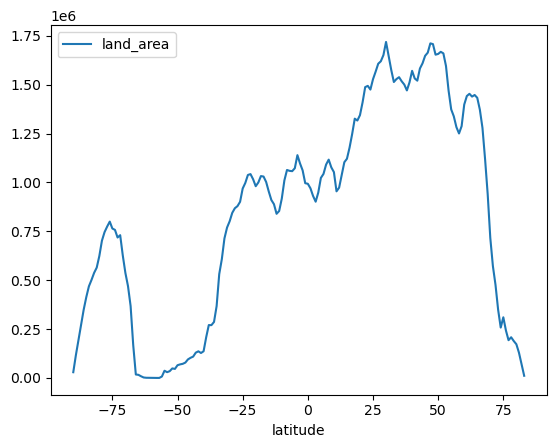

In [28]:
# plot
land_area_grouped.plot(x='latitude', y='land_area')